In [220]:
import numpy as np
import matplotlib.pyplot as plt

class EM:
    p = None
    dim = None # dimension of the data space
    n_points = None # Number of data points
    n_clusters = None # Number of clusters
    py = None # The prior probability vector of py_j values
    X = None # the data
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        return
    
    def initialize(self):
        # init p, based on random X but keep all values non zero     
        self.p = np.zeros(shape = (self.dim, self.n_clusters))
        samples = np.random.randint(0, self.n_points-1, self.n_clusters)
        for i, index in enumerate(samples):
            self.p[:, i] = (self.X[index, :] + 1)/(np.sum(self.X[index, :]) + self.dim)        
        
        # the prior
        self.py = np.ones(shape = self.n_clusters)/self.n_clusters
        return
    
    def fit(self, X):
        self.n_points = X.shape[0]
        self.dim = X.shape[1]
        self.X = X
        self.initialize();
        i = 1
        w_old = None
        while i < 100:
            w = self.e_step()
            self.m_step(w)
            
            # check for converge
            if (w_old is not None):
                dist = np.linalg.norm(w - w_old)
                if dist < 0.00001:
                    break
            w_old = np.copy(w)
            
            i = i + 1
            
        print("Converged in {} iterations\n".format(i))
        return
    
    def e_step(self):
        W = np.dot(self.X, np.log(self.p)) + np.log(self.py)
        maxs = W.max(axis=1)
        W = (W.T - maxs).T
        W = (W.T - np.log(np.sum(np.exp(W), axis = 1))).T
        W = np.exp(W)
        return W
    
    def m_step(self, W):
        self.py = np.sum(W, axis = 0)/self.n_points
        self.p = np.dot(self.X.T, W) + 1.0/self.dim
        
        colsum = np.sum(self.p, axis = 0)
        self.p = self.p/colsum
        return
        

Converged in 14 iterations



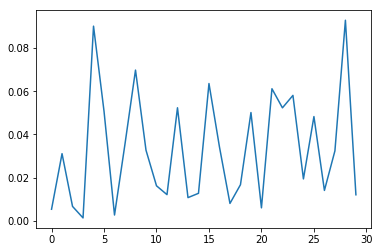

1: evidence, set, error, data, model, weight, bayesian, network, training, net
2: unit, network, input, learning, model, pattern, weight, set, training, layer
3: eeg, component, subject, signal, artifact, data, response, stimulus, trial, task
4: optimization, objective, neural, dynamic, neuron, foa, method, function, net, mjolsness
5: set, algorithm, training, data, function, error, learning, network, classifier, vector
6: algorithm, function, network, learning, model, problem, approximation, error, weight, neural
7: network, signal, weight, output, charge, filter, analog, transfer, jutten, chip
8: network, input, unit, output, training, system, learning, data, representation, set
9: network, model, neural, system, input, output, function, signal, training, set
10: model, data, function, set, network, input, method, distribution, gaussian, error
11: image, network, images, recognition, object, algorithm, input, neural, distance, pattern
12: model, orientation, dominance, ocular, map, p

In [222]:
# Load the data
nips_data = np.loadtxt('docword.nips.txt', skiprows=3, dtype=int)
X = np.zeros(shape=(1500, 12419))

# Prepare X
for row in nips_data:
    X[row[0]-1][row[1] -1] = row[2]

em = EM(n_clusters=30)
em.fit(X)

plt.plot(em.py)
plt.show()

words = [line.strip() for line in open('vocab.nips.txt')]

for j in range(30):
    print("{}: ".format(j+1) + ", ".join(list(np.array(words)[np.argsort(em.p[:,j])[::-1][0:10]])))
    
